Importing all the essential libraries.

In [72]:
import sqlalchemy as sa
import requests
import nest_asyncio
from requests_html import AsyncHTMLSession
import os
import xmltodict
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime
import aiohttp
import asyncio

My connection to DataGrip:

In [73]:
db_secret = {
    'drivername' : 'postgresql+psycopg2',
    'host'      : 'mmai5100postgres.canadacentral.cloudapp.azure.com',
    'port'      : '5432',
    'username'  : 'supragya',
    'password'  : '2023!Schulich',
    'database'  : 'supragya_db'
}

In [74]:
db_connection_url = sa.engine.URL.create(
    drivername = db_secret['drivername'],
    username   = db_secret['username'],
    password   = db_secret['password'],
    host       = db_secret['host'],
    port       = db_secret['port'],
    database   = db_secret['database']
)

In [75]:
engine = sa.create_engine(db_connection_url)

### Current Weather API

In [76]:
appid = 'd4feb9498d07a2d88b6cbd9812484295'
lat=43.6548
lon= -79.3883
units= 'metric'
limit = 10000
offset = 0

current_weather_api_url = 'https://api.openweathermap.org/data/2.5/weather?lat={}&lon={}&units={}&appid={}&limit={}&offset={}'.format(lat, lon, units, appid, limit, offset)

print(current_weather_api_url)

https://api.openweathermap.org/data/2.5/weather?lat=43.6548&lon=-79.3883&units=metric&appid=d4feb9498d07a2d88b6cbd9812484295&limit=10000&offset=0


In [77]:
api_response = requests.get(current_weather_api_url)

In [78]:
data = api_response.json()

In [79]:
data_list = []

dt = pd.to_datetime(data['dt'], unit='s')
sys_sunrise = pd.to_datetime(data['sys']['sunrise'], unit='s')
sys_sunset = pd.to_datetime(data['sys']['sunset'], unit='s')

data_dict = {
    'timezone': data['timezone'],
    'id': data['id'],
    'name': data['name'],
    'coord_lon': data['coord']['lon'],
    'coord_lat': data['coord']['lat'],
    'cod': data['cod'],
    'weather_main': data['weather'][0]['main'],
    'weather_description': data['weather'][0]['description'],
    'weather_icon': data['weather'][0]['icon'],
    'base': data['base'],
    'main_temp': data['main']['temp'],
    'main_feels_like': data['main']['feels_like'],
    'main_temp_min': data['main']['temp_min'],
    'main_temp_max': data['main']['temp_max'],
    'main_pressure': data['main']['pressure'],
    'main_humidity': data['main']['humidity'],
    'visibility': data['visibility'],
    'wind_speed': data['wind']['speed'],
    'wind_deg': data['wind']['deg'],
    'clouds_all': data['clouds']['all'],
    'dt': dt,
    'sys_id': data['sys']['id'],
    'sys_country': data['sys']['country'],
    'sys_sunrise': sys_sunrise,
    'sys_sunset': sys_sunset
}

data_list.append(data_dict)

current_weather_df = pd.DataFrame(data_list)


In [80]:
current_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timezone             1 non-null      int64         
 1   id                   1 non-null      int64         
 2   name                 1 non-null      object        
 3   coord_lon            1 non-null      float64       
 4   coord_lat            1 non-null      float64       
 5   cod                  1 non-null      int64         
 6   weather_main         1 non-null      object        
 7   weather_description  1 non-null      object        
 8   weather_icon         1 non-null      object        
 9   base                 1 non-null      object        
 10  main_temp            1 non-null      float64       
 11  main_feels_like      1 non-null      float64       
 12  main_temp_min        1 non-null      float64       
 13  main_temp_max        1 non-null      fl

In [81]:
current_weather_df.to_sql(
    name = 'Current_Weather_Information', 
    schema = 'complete_weather_data',
    con = engine,
    if_exists = 'replace',
    index = False,
    method = 'multi',
      dtype = {
    'timezone': sa.types.INTEGER,
    'id': sa.types.INTEGER,
    'name': sa.types.VARCHAR(255),
    'coord_lon': sa.types.FLOAT,
    'coord_lat': sa.types.FLOAT,
    'cod': sa.types.INTEGER,
    'weather_main': sa.types.VARCHAR(255),
    'weather_description': sa.types.VARCHAR(255),
    'weather_icon': sa.types.VARCHAR(255),
    'base': sa.types.VARCHAR(255),
    'main_temp': sa.types.FLOAT,
    'main_feels_like': sa.types.FLOAT,
    'main_temp_min': sa.types.FLOAT,
    'main_temp_max': sa.types.FLOAT,
    'main_pressure': sa.types.INTEGER,
    'main_humidity': sa.types.INTEGER,
    'visibility': sa.types.INTEGER,
    'wind_speed': sa.types.FLOAT,
    'wind_deg': sa.types.INTEGER,
    'clouds_all': sa.types.INTEGER,
    'dt': sa.types.TIMESTAMP,
    'sys_id': sa.types.INTEGER,
    'sys_country': sa.types.VARCHAR(255),
    'sys_sunrise': sa.types.TIMESTAMP,  # Change this to TIMESTAMP
    'sys_sunset': sa.types.TIMESTAMP   # Change this to TIMESTAMP

})

1

### Forecast Weather API

In [82]:
# I have used the same AppID mentioned above
lat=43.6548
lon= -79.3883
limit = 10000
offset = 0

forecast_weather_api_url = 'https://api.openweathermap.org/data/2.5/forecast?lat={}&lon={}&appid={}&limit={}&offset={}'.format(lat, lon, appid, limit, offset)

print(forecast_weather_api_url)

https://api.openweathermap.org/data/2.5/forecast?lat=43.6548&lon=-79.3883&appid=d4feb9498d07a2d88b6cbd9812484295&limit=10000&offset=0


In [83]:
api_response_forecast = requests.get(forecast_weather_api_url)

api_response_forecast

<Response [200]>

In [84]:
forecast_data = api_response_forecast.json()


In [85]:
data_list_forecast = []

for item in forecast_data['list']:
    dt = pd.to_datetime(item['dt'], unit='s')
    main_temp = item['main']['temp']
    main_feels_like = item['main']['feels_like']
    temp_min = item['main']['temp_min']
    temp_max = item['main']['temp_max']
    pressure = item['main']['pressure']
    humidity = item['main']['humidity']
    
    weather_id = item['weather'][0]['id']
    weather_main = item['weather'][0]['main']
    weather_description = item['weather'][0]['description']
    weather_icon = item['weather'][0]['icon']
    
    data_list_forecast.append({
        'dt': dt,
        'main_temp': main_temp,
        'main_feels_like': main_feels_like,
        'temp_min': temp_min,
        'temp_max': temp_max,
        'pressure': pressure,
        'humidity': humidity,
        'weather_id': weather_id,
        'weather_main': weather_main,
        'weather_description': weather_description,
        'weather_icon': weather_icon
    })

forecast_df = pd.DataFrame(data_list_forecast)

In [86]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt                   40 non-null     datetime64[ns]
 1   main_temp            40 non-null     float64       
 2   main_feels_like      40 non-null     float64       
 3   temp_min             40 non-null     float64       
 4   temp_max             40 non-null     float64       
 5   pressure             40 non-null     int64         
 6   humidity             40 non-null     int64         
 7   weather_id           40 non-null     int64         
 8   weather_main         40 non-null     object        
 9   weather_description  40 non-null     object        
 10  weather_icon         40 non-null     object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 3.6+ KB


In [87]:
forecast_df.to_sql(
    name = 'Forecast_Weather_Information', 
    schema = 'complete_weather_data',
    con = engine,
    if_exists = 'replace',
    index = False,
    method = 'multi',
      dtype = {
          'dt' : sa.types.TIMESTAMP,
          'main_temp' : sa.types.FLOAT,
          'main_feels_like': sa.types.FLOAT,
          'temp_min': sa.types.FLOAT,
          'temp_max': sa.types.FLOAT,
          'pressure': sa.types.INTEGER,
          'humidity': sa.types.INTEGER,
          'weather_id': sa.types.INTEGER,
          'weather_main': sa.types.VARCHAR(255),
          'weather_description': sa.types.VARCHAR(255),
          'weather_icon': sa.types.VARCHAR(255)
})

40

### Historical Weather API

In [88]:
key = '6fe878d1ff8d425185816caa82e1e9b8'
latitude= 43.6548
longitude= -79.3883
start_date = '2023-07-24'
end_date = '2023-08-07'
hourly = 'temperature_2m'
limit = 10000
offset = 0

history_weather_api_url = 'https://archive-api.open-meteo.com/v1/archive?latitude=43.6548&longitude=-79.3883&start_date=2023-07-24&end_date=2023-08-07&daily=weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timeformat=unixtime&timezone=America%2FNew_York'

print(history_weather_api_url)

https://archive-api.open-meteo.com/v1/archive?latitude=43.6548&longitude=-79.3883&start_date=2023-07-24&end_date=2023-08-07&daily=weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timeformat=unixtime&timezone=America%2FNew_York


In [89]:
history_api_response = requests.get(history_weather_api_url)

history_api_response

<Response [200]>

In [90]:
history_data = history_api_response.json()


In [91]:
columns_to_extract = [
    'time',
    'weathercode',
    'temperature_2m_max',
    'temperature_2m_min',
    'temperature_2m_mean',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'apparent_temperature_mean',
    'sunrise',
    'sunset',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum',
    'precipitation_hours',
    'windspeed_10m_max',
    'windgusts_10m_max',
    'winddirection_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]

daily_data = {column: [] for column in columns_to_extract}

for column in columns_to_extract:
    daily_data[column] = history_data['daily'][column]

history_df = pd.DataFrame(daily_data)
history_df.head()

,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,1690171200,63,25.3,18.1,21.9,27.0,19.7,23.9,1690192703,1690246182,4.5,4.5,0.0,6.0,15.3,37.1,239.0,21.46,3.89
1,1690257600,51,25.3,17.8,22.0,28.7,19.3,24.5,1690279164,1690332522,0.3,0.3,0.0,3.0,11.8,23.4,231.0,21.98,4.11
2,1690344000,63,27.8,20.7,24.2,29.5,21.8,25.7,1690365626,1690418860,6.4,6.4,0.0,4.0,22.1,47.2,213.0,23.19,4.89
3,1690430400,63,27.6,21.7,24.3,30.1,23.5,27.2,1690452089,1690505197,23.8,23.8,0.0,11.0,20.7,49.3,279.0,19.91,3.96
4,1690516800,51,28.6,19.3,24.4,32.5,21.2,27.3,1690538552,1690591532,0.2,0.2,0.0,1.0,14.5,32.0,239.0,23.22,4.58


In [92]:
history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   time                        15 non-null     int64  
 1   weathercode                 15 non-null     int64  
 2   temperature_2m_max          15 non-null     float64
 3   temperature_2m_min          15 non-null     float64
 4   temperature_2m_mean         14 non-null     float64
 5   apparent_temperature_max    15 non-null     float64
 6   apparent_temperature_min    15 non-null     float64
 7   apparent_temperature_mean   14 non-null     float64
 8   sunrise                     15 non-null     int64  
 9   sunset                      15 non-null     int64  
 10  precipitation_sum           14 non-null     float64
 11  rain_sum                    14 non-null     float64
 12  snowfall_sum                14 non-null     float64
 13  precipitation_hours         15 non-nu

In [93]:
history_df['time'] = pd.to_datetime(history_df['time'], unit='s')
history_df['sunrise'] = pd.to_datetime(history_df['time'], unit='s')
history_df['sunset'] = pd.to_datetime(history_df['time'], unit='s')


dtype_dict = {
    'time': sa.types.TIMESTAMP(timezone=True),
    'weathercode': sa.types.INTEGER,
    'temperature_2m_max': sa.types.FLOAT,
    'temperature_2m_min': sa.types.FLOAT,
    'temperature_2m_mean': sa.types.FLOAT,
    'apparent_temperature_max': sa.types.FLOAT,
    'apparent_temperature_min': sa.types.FLOAT,
    'apparent_temperature_mean': sa.types.FLOAT,
    'sunrise': sa.types.TIMESTAMP(timezone=True),
    'sunset': sa.types.TIMESTAMP(timezone=True),
    'precipitation_sum': sa.types.FLOAT,
    'rain_sum': sa.types.FLOAT,
    'snowfall_sum': sa.types.FLOAT,
    'precipitation_hours': sa.types.FLOAT,
    'windspeed_10m_max': sa.types.FLOAT,
    'windgusts_10m_max': sa.types.FLOAT,
    'winddirection_10m_dominant': sa.types.FLOAT,
    'shortwave_radiation_sum': sa.types.FLOAT,
    'et0_fao_evapotranspiration': sa.types.FLOAT
}

history_df.to_sql(
    name='History_Weather_Information',
    schema='complete_weather_data',
    con=engine,
    if_exists='replace',
    index=False,
    method='multi',
    dtype=dtype_dict
)

15

### Alert Weather API

 With the help of AsyncHTML session we can perform asynchronous web requests, enabling concurrent handling of multiple requests without blocking the main execution.

In [94]:
nest_asyncio.apply()
asession = AsyncHTMLSession()

In [95]:
async def fetch_website(weburl):
    url = weburl
    r = await asession.get(url)
    
    if r.status_code == 200:
        print(f"Successfully fetched data from {url}")
    else:
        print(f"Failed to fetch data from {url}, status code: {r.status_code}")

    await r.html.arender(sleep=1)
    
    href_list = r.html.find('pre a[href]')
    href_values = [link.attrs['href'] for link in href_list]

    return href_values


In [96]:
weburl = 'https://dd.weather.gc.ca/alerts/cap/' #website 
href_values_list = asession.loop.run_until_complete(fetch_website(weburl))
Today = href_values_list[-1]
print("----------------------")
print("Today's Date : ",Today[0:4],"-",Today[4:6],"-",Today[6:8])
print("----------------------")
new_web_url = weburl+Today+'CWTO/'
print(new_web_url) # I appended "CWTO" at the end of the URL because this specific folder encompasses weather alerts for Toronto.
print("----------------------")
new_href_values_list = asession.loop.run_until_complete(fetch_website(new_web_url))
today_folder = new_href_values_list[-1]
print("----------------------")
print("Today's folder number: ",today_folder)
print("----------------------")
target_url = new_web_url+today_folder
print("Target URL",target_url)
print("----------------------")
new_href_values_list = asession.loop.run_until_complete(fetch_website(target_url))
print("----------------------")
file_name = new_href_values_list[-1]
print("XML file containg data: ", file_name)
print("----------------------")
latest_file = target_url+file_name
print("Target File:", latest_file) 

'\nweburl = \'https://dd.weather.gc.ca/alerts/cap/\' #website \nhref_values_list = asession.loop.run_until_complete(fetch_website(weburl))\nToday = href_values_list[-1]\nprint("----------------------")\nprint("Today\'s Date : ",Today[0:4],"-",Today[4:6],"-",Today[6:8])\nprint("----------------------")\nnew_web_url = weburl+Today+\'CWTO/\'\nprint(new_web_url) # I appended "CWTO" at the end of the URL because this specific folder encompasses weather alerts for Toronto.\nprint("----------------------")\nnew_href_values_list = asession.loop.run_until_complete(fetch_website(new_web_url))\ntoday_folder = new_href_values_list[-1]\nprint("----------------------")\nprint("Today\'s folder number: ",today_folder)\nprint("----------------------")\ntarget_url = new_web_url+today_folder\nprint("Target URL",target_url)\nprint("----------------------")\nnew_href_values_list = asession.loop.run_until_complete(fetch_website(target_url))\nprint("----------------------")\nfile_name = new_href_values_list[


I am planning to download this file and save it locally on my computer for future parsing purposes.

In [97]:
directory_path = (r"C:\Users\supra\OneDrive\Desktop\Schulich MBAN\Sem- 1\Database fundamentals\WeatherAPI_file") # replace the file path
alert = "example_file.xml" 
full_path = os.path.join(directory_path, alert)

I am storing the file in the 'req' variable and subsequently reading it.

In [ ]:
req = requests.get(latest_file)
with open(full_path, 'wb') as f:
    for chunk in req.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)

Now that we have the XML file downloaded locally, I will utilize the XMLDict library to read the file:

Reference: https://www.askpython.com/python-modules/xmltodict-module

In [98]:
with open(full_path, 'r') as xml_file:
    xml_data = xml_file.read()
data_dict = xmltodict.parse(xml_data)

In [99]:
# I implemented a try-catch block to ensure that errors are properly handled.
# I am also displaying the information that we obtain from the XML file.
try:
    data_dict = xmltodict.parse(xml_data)
    
    info_list = data_dict['alert']['info']
    if not isinstance(info_list, list):
        info_list = [info_list]  
    
    for info in info_list:
        if info.get('language') == 'en-CA': # I only require information presented in the English language.
            language = info.get('language')
            category = info.get('category')
            event = info.get('event')
            responseType = info.get('responseType')
            urgency = info.get('urgency')
            severity = info.get('severity')
            certainty = info.get('certainty')
            audience = info.get('audience')
            effective = info.get('effective')
            expires = info.get('expires')
            senderName = info.get('senderName')
            headline = info.get('headline')
            description = info.get('description')
            
            print("Language:", language)
            print("Category:", category)
            print("Event:", event)
            print("Response Type:", responseType)
            print("Urgency:", urgency)
            print("Severity:", severity)
            print("Certainty:", certainty)
            print("Audience:", audience)
            print("Effective:", effective)
            print("Expires:", expires)
            print("Sender Name:", senderName)
            print("Headline:", headline)
            print("Description:", description)
            
            area_list = info['area']
            if not isinstance(area_list, list):
                area_list = [area_list] 
            
            polygon_list = []
            first_polygon = None
            for area in area_list:
                polygon = area.get('polygon')
                if polygon and not first_polygon:
                    first_polygon = polygon
                    polygon_coordinates = polygon.split()
                    
            if first_polygon: # I'm aiming to extract values from the initial occurrence of the polygon.
                points_str = first_polygon.split()
                polygon_points = []

                for point_str in points_str:
                    lat, lon = map(float, point_str.split(','))
                    polygon_points.append((lat, lon))

                print("Polygon Points:", polygon_points)
            
except Exception as e:
    print("An error occurred:", e)

Language: en-CA
Category: Met
Event: squall
Response Type: Monitor
Urgency: Immediate
Severity: Severe
Certainty: Likely
Audience: general public
Effective: 2023-08-12T16:47:57-00:00
Expires: 2023-08-12T20:15:06-00:00
Sender Name: Environment Canada
Headline: squall warning in effect
Description: Squalls with wind gusts up to 45 knots, frequent lightning, waterspout activity and poor to very poor visibility in showers heavy at times are expected or occurring in the area.

A cluster of thunderstorms over eastern Lake Ontario may give gusts near 45 knots early this afternoon and then clear out in the middle of the afternoon.

###

Poor to very poor visibility may contribute to voyage delays and make marine navigation hazardous.

Please continue to monitor alerts and forecasts issued by Environment Canada. For more information monitor Canadian Coast Guard radio or Weatheradio stations.
Polygon Points: [(44.0963, -76.5159), (44.0862, -76.4895), (44.0731, -76.455), (43.6311, -76.7966), (43.

By utilizing this function "point_inside_polygon", we can determine whether a provided latitude and longitude value lies within the confines of a polygon or not.

In [100]:
def point_inside_polygon(x, y, poly):
    n = len(poly)
    inside = False
    p1x, p1y = poly[0]
    for i in range(n + 1):
        p2x, p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

I am in the process of creating a dataframe that will contain latitude and longitude values for various areas within Toronto. To achieve this, I downloaded a CSV file from Kaggle and extracted additional data from a website. This compilation will result in the formation of my final dataframe.

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497


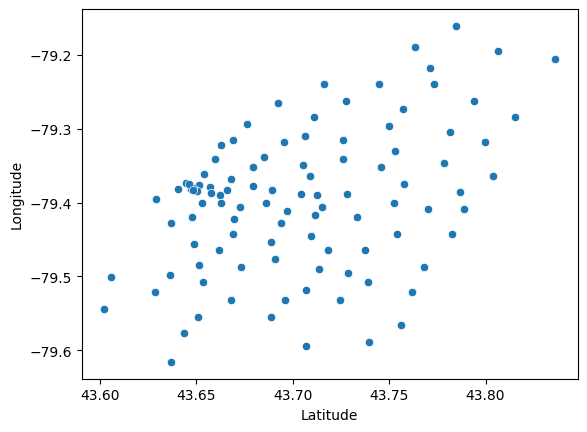

In [101]:
location_df = pd.read_csv("https://raw.githubusercontent.com/supragyabajpai/SchulichJourney_DataScience/main/DataBase/Geospatial_Coordinates.csv")
sns.scatterplot(data = location_df, x = "Latitude", y = "Longitude")
location_df.head(2)

Web Scrapping

In [102]:

url = "https://www.genguide.com.ng/toronto-postal-code/"
response = requests.get(url)
html_content = response.text
soup = BeautifulSoup(html_content, "html.parser")
figure = soup.find("figure", class_="wp-block-table")
table = figure.find("table")

if table is not None:
    neighborhoods = []
    districts = []

    for row in table.find_all("tr")[1:]:
        columns = row.find_all("td")
        district = columns[1].text
        neighborhood = columns[2].text.strip()

        if district != "Not assigned":
            districts.append(district)
            neighborhoods.append(neighborhood)

    data = {
        "District": districts,
        "Neighborhood": neighborhoods
    }

    neighborhood_df = pd.DataFrame(data) 
else:
    print("Table not found on the page.")

neighborhood_df.head(2)


,District,Neighborhood
0,Adelaide,M5H
1,Agincourt North,M1V


I will now perform a join operation to combine the two dataframes I possess.






In [103]:
merged_df = pd.merge(neighborhood_df, location_df, left_on='Neighborhood', right_on='Postal Code', how='right')
merged_df.head(3)

,District,Neighborhood,Postal Code,Latitude,Longitude
0,Malvern,M1B,M1B,43.806686,-79.194353
1,Rouge,M1B,M1B,43.806686,-79.194353
2,Highland Creek,M1C,M1C,43.784535,-79.160497


With our table ready, we can proceed to provide it as an input to our function "point_inside_polygon." This function will help determine whether the given latitude and longitude fall within the alert area.

In [104]:
merged_df['InsidePolygon'] = merged_df.apply(lambda row: point_inside_polygon(row['Longitude'], row['Latitude'], polygon_points), axis=1)

In [105]:
merged_df.head(10)

,District,Neighborhood,Postal Code,Latitude,Longitude,InsidePolygon
0,Malvern,M1B,M1B,43.806686,-79.194353,False
1,Rouge,M1B,M1B,43.806686,-79.194353,False
2,Highland Creek,M1C,M1C,43.784535,-79.160497,False
3,Port Union,M1C,M1C,43.784535,-79.160497,False
4,Rouge Hill,M1C,M1C,43.784535,-79.160497,False
5,Guildwood,M1E,M1E,43.763573,-79.188711,False
6,Morningside,M1E,M1E,43.763573,-79.188711,False
7,West Hill,M1E,M1E,43.763573,-79.188711,False
8,Woburn,M1G,M1G,43.770992,-79.216917,False
9,Cedarbrae,M1H,M1H,43.773136,-79.239476,False


An observation can be made from the table above: there are no True values present in the InsidePolygon column. This indicates the absence of any current alerts in Toronto.

Let's incorporate details regarding the alerts into our dataframe. If the value in the InsidePolygon column is False, we can label it as "No alert."


In [106]:
for i in merged_df['InsidePolygon']:
    if i == True:
        merged_df['Event'] = event
        merged_df['Effective'] = effective
        merged_df['Expires'] = expires
        merged_df['Headline'] = headline
        merged_df['Description'] = description
    else:
        merged_df['Event'] = "No Alert"
        merged_df['Effective'] = "No Alert"
        merged_df['Expires'] = "No Alert"
        merged_df['Headline'] = "No Alert"
        merged_df['Description'] = "No Alert"
        

In [107]:
merged_df.head()

,District,Neighborhood,Postal Code,Latitude,Longitude,InsidePolygon,Event,Effective,Expires,Headline,Description
0,Malvern,M1B,M1B,43.806686,-79.194353,False,No Alert,No Alert,No Alert,No Alert,No Alert
1,Rouge,M1B,M1B,43.806686,-79.194353,False,No Alert,No Alert,No Alert,No Alert,No Alert
2,Highland Creek,M1C,M1C,43.784535,-79.160497,False,No Alert,No Alert,No Alert,No Alert,No Alert
3,Port Union,M1C,M1C,43.784535,-79.160497,False,No Alert,No Alert,No Alert,No Alert,No Alert
4,Rouge Hill,M1C,M1C,43.784535,-79.160497,False,No Alert,No Alert,No Alert,No Alert,No Alert


In [108]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   District       202 non-null    object 
 1   Neighborhood   202 non-null    object 
 2   Postal Code    208 non-null    object 
 3   Latitude       208 non-null    float64
 4   Longitude      208 non-null    float64
 5   InsidePolygon  208 non-null    bool   
 6   Event          208 non-null    object 
 7   Effective      208 non-null    object 
 8   Expires        208 non-null    object 
 9   Headline       208 non-null    object 
 10  Description    208 non-null    object 
dtypes: bool(1), float64(2), object(8)
memory usage: 16.6+ KB


In [109]:
dtype_mapping = {
    'District': sa.types.VARCHAR(50),  
    'Neighborhood': sa.types.VARCHAR(50),
    'Postal Code': sa.types.VARCHAR(15),  
    'Latitude': sa.types.FLOAT,
    'Longitude': sa.types.FLOAT,
    'InsidePolygon': sa.types.BOOLEAN,
    'Event': sa.types.VARCHAR(50),
    'Effective': sa.types.VARCHAR(50),
    'Expires': sa.types.VARCHAR(50),
    'Headline': sa.types.VARCHAR(50),
    'Description': sa.types.VARCHAR(100)  
}

merged_df.to_sql(
    name='Alert_Weather_Information',
    schema='complete_weather_data',
    con=engine,
    if_exists='replace',
    index=False,
    method='multi',
    dtype=dtype_mapping
)


208